In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['y_train.csv', 'sample_submission.csv', 'X_test.csv', 'X_train.csv']


In [2]:
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [3]:
x_train = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
x_test = pd.read_csv('../input/X_test.csv')

For every series, we have 128 observations and hence the number of rows in the x_train and y_train do not match. We should pre-process the x_train appropirately to get it down to the same dimension as y_train.

In [4]:
x_train.groupby('series_id').count().head(3)

,row_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
series_id,,,,,,,,,,,,
0,128,128,128,128,128,128,128,128,128,128,128,128
1,128,128,128,128,128,128,128,128,128,128,128,128
2,128,128,128,128,128,128,128,128,128,128,128,128


In [5]:
y_train.head(3)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete


In [6]:
y_train['group_id'].unique()

array([13, 31, 20, 22,  1, 34, 33, 11, 26, 25, 12,  7, 21,  8,  9, 28, 15,
       27, 35, 32, 23, 14, 30,  3, 29, 16,  0, 10, 19,  4, 18,  6, 17,  5,
        2, 24, 69, 70, 71, 60, 62, 59, 45, 56, 41, 53, 40, 68, 49, 46, 42,
       38, 61, 43, 51, 44, 55, 65, 37, 57, 54, 72, 64, 66, 36, 48, 47, 52,
       39, 58, 50, 63, 67])

Checking the number of trainnig samples per class. Highest is concrete and lowest is hard_tiles

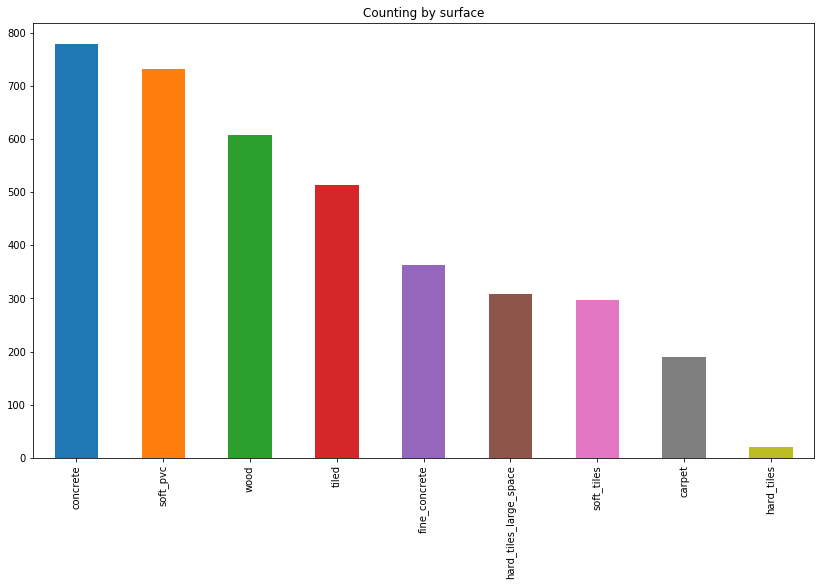

In [7]:
plt.figure(figsize = (10,10))
ax = y_train['surface'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Counting by surface")

To handle the length difference between the x_trai nand y_train, we roll up x_train such that it is the same size as y_train. We subsequently convert them to numpy arrays to pass into the deep learning keras model.

In [8]:
x_train = x_train.drop(['row_id', "series_id", "measurement_number"], axis=1)
y_train = y_train.drop(['group_id', "series_id"], axis=1)

In [9]:
x_train =x_train.values.reshape((3810, 128, 10))
y_train =y_train.values.reshape((3810, 1))

In [10]:
print(x_train.shape)
print(y_train.shape)


(3810, 128, 10)
(3810, 1)


In [11]:
y_train[1:5]

array([['concrete'],
       ['concrete'],
       ['concrete'],
       ['soft_tiles']], dtype=object)

The labels are strings and hence need to be converted into numbers that a deep learning model can understand. Thankfully, keras does that for us as well!

In [12]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
print('y_train shape is {}'.format(str(y_train.shape)))

y_train shape is (3810,)


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Split the train data into train and validation files.

In [13]:
x_tr, x_te,y_tr, y_te = train_test_split(x_train, y_train, test_size = 0.15)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

(3238, 128, 10) (3238,) (572, 128, 10) (572,)


In [14]:
model = Sequential()
model.add(LSTM(128, dropout=0.1, return_sequences = True,recurrent_dropout=0.1, input_shape=((128, 10))))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(9, activation='softmax'))


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 128)          71168     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
__________

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model_fit = model.fit(x_tr, y_tr,
                    batch_size=64,
                    epochs=150,
                    verbose=1,
                    validation_data=(x_te, y_te))

Train on 3238 samples, validate on 572 samples
Epoch 1/150
3238/3238 [==============================] - 32s 10ms/step - loss: 2.0652 - acc: 0.1998 - val_loss: 2.0061 - val_acc: 0.2745
Epoch 2/150
3238/3238 [==============================] - 28s 9ms/step - loss: 1.9954 - acc: 0.2427 - val_loss: 1.9409 - val_acc: 0.2675
Epoch 3/150
3238/3238 [==============================] - 28s 9ms/step - loss: 1.8854 - acc: 0.2903 - val_loss: 1.7330 - val_acc: 0.3217
Epoch 4/150
3238/3238 [==============================] - 28s 9ms/step - loss: 1.7604 - acc: 0.3190 - val_loss: 1.7059 - val_acc: 0.3042
Epoch 5/150
3238/3238 [==============================] - 27s 8ms/step - loss: 1.7144 - acc: 0.3289 - val_loss: 1.5765 - val_acc: 0.3374
Epoch 6/150
3238/3238 [==============================] - 27s 8ms/step - loss: 1.7044 - acc: 0.3416 - val_loss: 1.5682 - val_acc: 0.3339
Epoch 7/150
3238/3238 [==============================] - 28s 9ms/step - loss: 1.6531 - acc: 0.3521 - val_loss: 1.5291 - val_acc: 0.4301


Pre-process the x_test in the same way as x_train to generate appropriate input data for the model to predict on.

In [18]:
x_test = x_test.drop(['row_id', "series_id", "measurement_number"], axis=1)
x_test =x_test.values.reshape((3816, 128, 10))

Predict on the model and submit to the csv file!

In [19]:
prediction = model.predict(x_test)
prediction=np.argmax(prediction, axis=1)
y_preds = le.inverse_transform(prediction)

In [20]:
submission = pd.read_csv("../input/sample_submission.csv")
submission['surface'] = y_preds
submission.to_csv('lstm_with_Fully_connected_layers.csv', index=False)